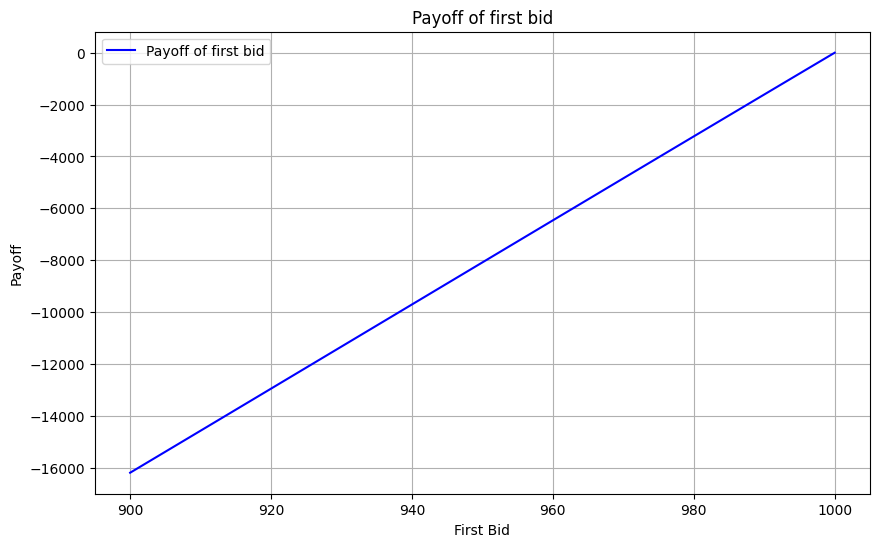

In [1]:
from sympy import lambdify
from sympy import symbols, integrate, solve
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib.pyplot as plt

# Define the range of prices from 900 to 1000
prices = np.linspace(900, 1000, 101)

# Calculate the probability for each price using the linear probability distribution
# Since k = 1/5000 and probability scales linearly from least likely at 900 to most likely at 1000
probabilityBidEqualsAsk = (prices - 900) * (1/5000)

# Calculate the probability for each price using the linear probability distribution
# Since k = 1/5000 and probability scales linearly from least likely at 900 to most likely at 1000
probabilityBidGreaterThanAsk = ((prices ** 2)/10000) - ((9 * prices)/50)
probabilityBidGreaterThanAsk += probabilityBidGreaterThanAsk[0]

probabilityBidIsLessThanAsk = 1 - probabilityBidGreaterThanAsk

# Calculate the payoff for each bid in the range
payoff = (1000 - prices) * probabilityBidGreaterThanAsk

# Plotting the prices vs their probability
plt.figure(figsize=(10, 6))
plt.plot(prices, payoff, label='Payoff of first bid', color='blue')
plt.xlabel('First Bid')
plt.ylabel('Payoff')
plt.title('Payoff of first bid')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
firstBid = 956
secondBid = 980



avgSecondBid = 990

maxPayoff = (0,0,0)
for firstBid in range(900, 1001):
    for secondBid in range(firstBid, 1001):

        # Define the interval
        start = 900
        stop = 1000

        # Number of samples
        n_samples = 100000

        # Create a linearly increasing probability density function (PDF) from 0 at start to 0.02 at stop
        # The PDF needs to be normalized so that its integral over the range equals 1.
        # The maximum value at 'stop' is 0.02, and the slope of the line connecting the start and stop is 0.02/(stop-start).
        slope = 0.02 / (stop - start)
        # To normalize the PDF, we find the area under the linear curve from start to stop and divide the function by this area.
        area = 0.5 * (stop - start) * 0.02
        normalized_slope = slope / area


        # Generate uniform samples from 0 to 1
        uniform_samples = np.random.uniform(0, 1, n_samples)

        # Transform the uniform samples to our desired distribution using the inverse of the CDF.
        # The CDF is obtained by integrating the PDF: CDF(x) = 0.5 * normalized_slope * (x - start)^2
        # Solving for x gives us the inverse CDF: x = sqrt((2 * CDF) / normalized_slope) + start
        # But first, we need to map our uniform samples to the CDF values that correspond to our PDF.
        # Since the area under our PDF from 'start' to 'stop' is normalized to 1, our uniform samples directly represent CDF values.
        samples = np.sqrt(2 * uniform_samples / normalized_slope) + start

# sample_900s = samples[samples <= 900]
# print(len(sample_900s))

# sample_1000s = samples[samples > 999]
# print(len(sample_1000s))

# counts, bins = np.histogram(samples)
# plt.figure(figsize=(10, 6))
# plt.stairs(counts, bins)

        results = []
        for sample in samples:
            if firstBid >= sample:
                results.append(1000 - firstBid)
                continue

            if secondBid >= sample:
                if secondBid < avgSecondBid:
                    results.append(1000 - avgSecondBid)
                    continue

                results.append(1000 - secondBid)
                continue

            results.append(0)
        
        avg_result = sum(results) / len(results)
        if avg_result > maxPayoff[0]:
            maxPayoff = (avg_result, firstBid, secondBid)
            # print(maxPayoff)

print(maxPayoff)
# counts, bins = np.histogram(results)
# plt.figure(figsize=(10, 6))
# plt.stairs(counts, bins)

(18.93818, 961, 990)


In [38]:
import pandas as pd

# Construct all possible bids
first_bids_df = pd.DataFrame(list(range(950, 1001)), columns=['firstBid'])
second_bids_df = pd.DataFrame(list(range(950, 1001)), columns=['secondBid'])
bids_df = pd.merge(first_bids_df, second_bids_df, how='cross')
df = bids_df[bids_df['secondBid'] >= bids_df['firstBid']]

# Construct samples
n_samples = 10000
slope = 0.02 / (stop - start)
area = 0.5 * (stop - start) * 0.02
normalized_slope = slope / area
uniform_samples = np.random.uniform(0, 1, n_samples)
samples = np.sqrt(2 * uniform_samples / normalized_slope) + 900
samples_df = pd.DataFrame(samples, columns=['sample'])

# Construct avg bids
avg_bids_df = pd.DataFrame(list(range(978, 1001)), columns=['avgBid'])

# Cross join the bids, samples, and avg_bids
df = pd.merge(df, samples_df, how='cross')
df = pd.merge(df, avg_bids_df, how='cross')

# Compute the payoff
df['payoff'] = None
df['payoff'] = np.where(df['firstBid'] >= df['sample'], 1000 - df['firstBid'], df['payoff'])
df['payoff'] = np.where(pd.isnull(df['payoff']) & (df['secondBid'] >= df['sample']) & (df['avgBid'] > df['secondBid']), 1000 - df['avgBid'], df['payoff'])
df['payoff'] = np.where(pd.isnull(df['payoff']) & (df['secondBid'] >= df['sample']), 1000 - df['secondBid'], df['payoff'])
df['payoff'] = np.where(pd.isnull(df['payoff']), 0, df['payoff'])

# Find total payoff for every firstBid, secondBid, and avgBid
payoff_df = df.groupby(['firstBid', 'secondBid', 'avgBid'])['payoff'].sum().reset_index()

# Find the maximum payoff for each avgBid
idx = payoff_df.groupby('avgBid')['payoff'].transform('max') == payoff_df['payoff']
payoff_df[idx].sort_values(by=['avgBid', 'firstBid', 'secondBid'], ascending=True)

,firstBid,secondBid,avgBid,payoff
2921,952,978,978,203168
5153,954,980,979,203082
5154,954,980,980,203082
6236,955,981,981,202678
6260,955,982,982,201915
7319,956,983,983,200643
7343,956,984,984,199720
7367,956,985,985,198526
7391,956,986,986,197004
7415,956,987,987,194810


: 

12.95568


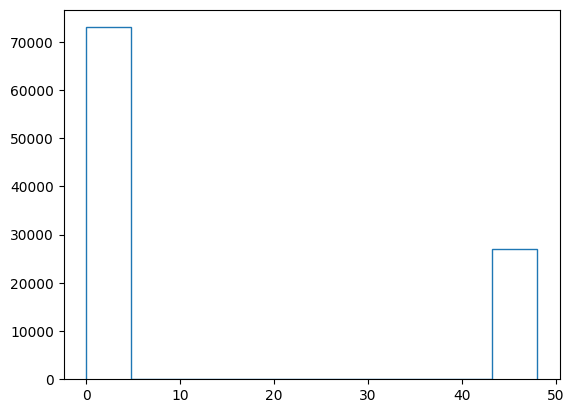

In [4]:
firstBid = 952
secondBid = 978

# Define the interval
start = 900
stop = 1000

# Number of samples
n_samples = 100000

# Create a linearly increasing probability density function (PDF) from 0 at start to 0.02 at stop
# The PDF needs to be normalized so that its integral over the range equals 1.
# The maximum value at 'stop' is 0.02, and the slope of the line connecting the start and stop is 0.02/(stop-start).
slope = 0.02 / (stop - start)
# To normalize the PDF, we find the area under the linear curve from start to stop and divide the function by this area.
area = 0.5 * (stop - start) * 0.02
normalized_slope = slope / area


# Generate uniform samples from 0 to 1
uniform_samples = np.random.uniform(0, 1, n_samples)

# Transform the uniform samples to our desired distribution using the inverse of the CDF.
# The CDF is obtained by integrating the PDF: CDF(x) = 0.5 * normalized_slope * (x - start)^2
# Solving for x gives us the inverse CDF: x = sqrt((2 * CDF) / normalized_slope) + start
# But first, we need to map our uniform samples to the CDF values that correspond to our PDF.
# Since the area under our PDF from 'start' to 'stop' is normalized to 1, our uniform samples directly represent CDF values.
samples = np.sqrt(2 * uniform_samples / normalized_slope) + start


results = []
for sample in samples:
    if firstBid >= sample:
        results.append(1000 - firstBid)
        continue

    results.append(0)

print(sum(results) / len(results))
counts, bins = np.histogram(results)
plt.stairs(counts, bins)